In [1]:
from ast import literal_eval
import pandas as pd
import requests

forta_api = "https://api.forta.network/graphql"
headers = {"content-type": "application/json"}

# start and end date needs to be in the format: YYYY-MM-DD
# START_DATE = "2022-09-13"
# END_DATE = "2022-09-14"
ALERT_COUNT_LIMIT = 1000000

query = """
query exampleQuery($input: AlertsInput) {
  alerts(input: $input) {
    alerts {
      name
      protocol
      findingType
      source {
        transactionHash
        block {
          number
          chainId
          timestamp
          hash
        }
        bot {
          id
        }
      }
      severity
      metadata
      alertId
      addresses
      description
      hash
    }
    pageInfo {
      hasNextPage
      endCursor {
        blockNumber
        alertId
      }
    }
  }
}
"""

query_variables = {
  "input": {
    "first": 100,
    "bots": ["0x8badbf2ad65abc3df5b1d9cc388e419d9255ef999fb69aac6bf395646cf01c14"]
  }
}

all_alerts = []
next_page_exists = True

while next_page_exists and len(all_alerts) < ALERT_COUNT_LIMIT:
    # query Forta API
    payload = dict(query=query, variables=query_variables)
    response = requests.request("POST", forta_api, json=payload, headers=headers)

    # collect alerts
    data = response.json()['data']['alerts']
    alerts = data['alerts']
    all_alerts += alerts

    # get next page of alerts if it exists
    next_page_exists = data['pageInfo']['hasNextPage']
    # endCursor contains alert Id and block number.
    # This is needed to get the next page of alerts.
    end_cursor = data['pageInfo']['endCursor']
    query_variables['input']['after'] = end_cursor

df = pd.DataFrame.from_dict(all_alerts)
# df.to_csv('forta-ice-phishing-alerts.csv')

print(len(df)) # size: ALERT_COUNT_LIMIT = 100000

### Extract relevant alert data, focusing on High priority Ethereum alerts.

In [2]:
# It takes a while to pull all alerts. We will focus our analysis on the period up to 16/09/2022

# column_converters = {
#     'source': literal_eval,
#     'metadata': literal_eval,
#     'addresses': literal_eval
# }

# df = pd.read_csv('forta-ice-phishing-alerts.csv', converters=column_converters)
# df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
# Extract chain id and block number.

chain_id = []
block_number = []
attacker = []
alerted_tx = []
timestamp = []

for i in range(len(df)):
    chain_id.append(df['source'][i]['block']['chainId'])
    block_number.append(df['source'][i]['block']['number'])
    attacker.append(df['description'][i].split(' ')[0])
    alerted_tx.append(df['source'][i]['transactionHash'])
    timestamp.append(df['source'][i]['block']['timestamp'])

df['chain_id'], df['block_number'], df['attacker'], df['alerted_tx'] = chain_id, block_number, attacker, alerted_tx

In [4]:
eth_alerts = df.loc[df['chain_id'] == 1].reset_index(drop=True)

print(len(eth_alerts))
print(len(eth_alerts.attacker.unique()))

19196
3410


In [5]:
# We're probably interested in repeat offenders. If not, at least we identify probable false positives. Services
# making transactions picked up by this bot will likely make more than one.

attacker_alert_count = {}

for attacker in eth_alerts.attacker.unique():
    attacker_alert_count[attacker] = len(eth_alerts.loc[eth_alerts.attacker == attacker])
    
eth_alerts['attacker_alert_count'] = [attacker_alert_count[attacker] for attacker in eth_alerts.attacker]

In [7]:
# The majority of high severity alerts are on Ethereum, followed by BSC and Polygon.
# Documentation detailing severity: https://ipfs.forta.network/ipfs/QmVgaxvojEARmqoYjhhRnE1q5fWo9qfJbkrTzCt11gvbXD

df.loc[df.severity == 'HIGH'].chain_id.value_counts()

1        1270
56        687
137       419
42161      63
250         2
43114       2
10          1
Name: chain_id, dtype: int64

In [44]:
# Many of the alerts created by this bot are for approvals to transfer assets, but it is not clear
# that transfers have actually gone through. Here we begin to focus on high severity alerts, or 
# alerts for actual transfer of assets.

bsc_alerts = df.loc[df.chain_id == 56].reset_index(drop=True)
bsc_high_alerts = bsc_alerts.loc[bsc_alerts.severity == 'HIGH'].reset_index(drop=True)

In [112]:
print(len(bsc_high_alerts.attacker.unique()))
bsc_high_alerts.attacker.value_counts()[:20]

73


0x38fD7cfF9Abecc077040FEe822eF9Cd3740460CC    127
0x9fb3aA15a719fa280467FD9e5cE6d178B6266772     66
0xeF386b59fDeE8633869088278dF97Bd91Dd9d2BC     63
0xBc89C038b452bACde7708d5A162bc8E3908f6A19     46
0xa98e2D07895E6Fd1012aFC7fBDad0340071F678C     33
0x6Bc375e5D626B423836D0cda7189B749E92e5625     30
0x54CC0De0a42eADf10dF8B282f865Be2d4e3C35dc     23
0x6ce1976eA40e86be51B76Ba6DC42153338Df889e     22
0xA182aAB7B51232FBFABC22d989f21d264B0B246f     21
0x8521Daa1998F25fC6ef472b0f333491C1f4049a3     17
0x2ceC6AD148D8a297747F32588767392632888888     16
0x4a12B423715BE8fa586CB71808E1aA4F0157C336     15
0x4A2a62d52c62B1CCBA42671f094213bBD290b40f     12
0xa3E16001f197005E72F36558Fd2FB88E18Cf2EDd     12
0x0a0fc875A7D2A4689613E32a36109ddF45F47600     12
0xFd523bBCE795DC34cd30fA3300FC56d668Dc33C3     11
0xd71751Becd1033c2164b6745F9985e1cA029d3DA     11
0xd5D80b11B8A9Ae6bdb6439Da4862a4140c3a294D     10
0x1e72b1274a7744d8363Ee3fD8c428a3131a99aE5      9
0xFC09c652d1E4d784B874Db2aded57cef3316b8ff      8


<AxesSubplot:>

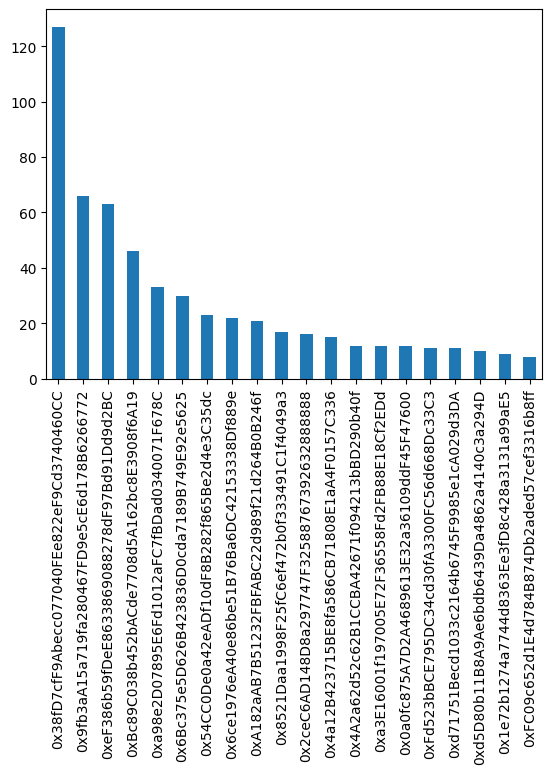

In [46]:
bsc_high_alerts.attacker.value_counts()[:20].plot(kind='bar')

In [47]:
poly_alerts = df.loc[df.chain_id == 137].reset_index(drop=True)
poly_high_alerts = poly_alerts.loc[poly_alerts.severity == 'HIGH'].reset_index(drop=True)

In [113]:
print(len(poly_high_alerts.attacker.unique()))
poly_high_alerts.attacker.value_counts()[:20]

21


0x1C019f874c3352558e28C5F77cd9a81a7E2C0604    120
0xE35F218EE8A3f3814C5162c164c225bDD77D4983    115
0x2DB1be60038D7CC34d4924c9b2b82baB86f437Ad     72
0x3231E3dbc3cE6C4651c328C66D98da75A8f0A0fb     18
0x2CCbB61ebB644766a2F05CB6ccb7D78BB5561Bee     17
0xDE2314093a0362c0D25255D5088865027861278f     16
0x203E2bBAEA9a3b24bcd08Ec85c211E36233A78eA     11
0x38fD7cfF9Abecc077040FEe822eF9Cd3740460CC     10
0x20e58dcbECc54baf4F6086C6bc76724330Fd5578      9
0x33B804b80D60AF041D150c7BeFbB957501D8dfcd      6
0xDDEDD2bedBFC30bBCf3267FcAd8952F4fd4DE511      4
0xFbC8468D2275326c71a2CBC5EAe9Ca0268Dc058F      4
0x52A76a606AC925f7113B4CC8605Fe6bCad431EbB      3
0xa98e2D07895E6Fd1012aFC7fBDad0340071F678C      3
0xFc2579ec19758D246bDc3af8F91dad410Dd7872e      2
0x34719BA5bfCc72148584bc78D18c415C88C8a97f      2
0x57A72cE4fd69eBEdEfC1a938b690fbf11A7Dff80      2
0xdc026b7656210386BCCDBB3B01bbf2077350a5c7      2
0x2978c1Aa5F0D81FEB73b070fB38C4B8F1C46624F      1
0x5435864B9d27B5DFFAdBB8320D9f8946B3ce617f      1


<AxesSubplot:>

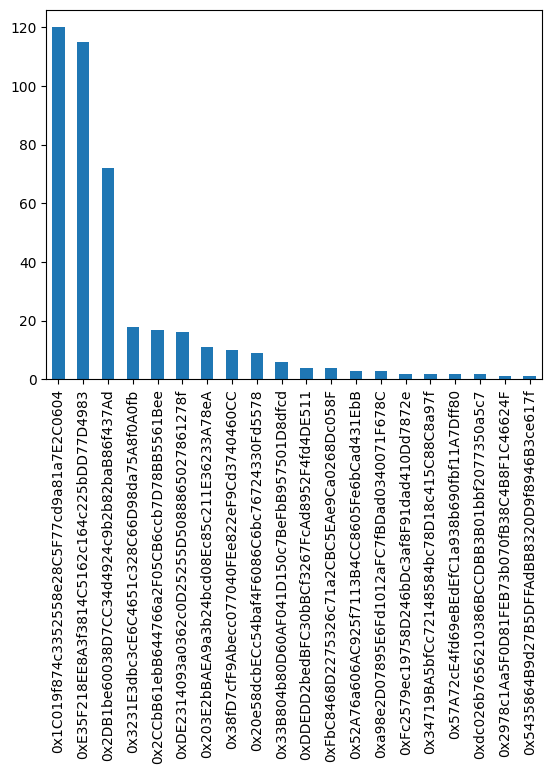

In [48]:
poly_high_alerts.attacker.value_counts()[:20].plot(kind='bar')

In [100]:
eth_high_alerts = eth_alerts.loc[eth_alerts['severity'] == 'HIGH'].reset_index(drop=True)
eth_low_alerts = eth_alerts.loc[eth_alerts['severity'] == 'LOW'].reset_index(drop=True)

eth_high_alerts.attacker.value_counts()[:20]

0x2aAa484D2a19e0B3B84d72280558e4D45beB6264    397
0xC28d5d922eB85c51b114f35242216Ae792f29F16    116
0x3A289C8c1c27d6FEAE33fB158f90abdbfea24397    106
0xf8238a3dd9a67b8419412eDE613A06D73Ffc2D93     39
0x9CeF2D0Ac483fb342dE51460949dfC6A139c398D     36
0x98A89ea045d8EC5Cf38Ffc2acD1774baB5f67b36     23
0xC1A0C058d417496e5ad26702e016d9f9dA00614E     22
0x6fe2eE963643Ac7E480aacaFEfddb3683E38fcf9     22
0xCFe3B948E8Bd94d4F22b900A88825Fc1E6695956     21
0xB66bD00923c7e9C7D368A79004Be27E19F241275     20
0x29D8475c7e3ee2c504242a243c5C6cAd16D8499A     20
0x0Bfdd118608107C724Eda6cAf3530fA6303efC8C     19
0x5BcF729e1815879878dBbCb5aF17978a36dDBF10     19
0x0008A91c630A458C1B356cb6c01C04943Dd90729     19
0x7646d029852D339af30FE76801B41C790981FFcb     19
0xeb3072911B0Cd5b0db835310b299Ab3ef429E53C     16
0x064a1e3Ce94cd44d81949CFF3170E5b4d3476df4     13
0x9C5c4Ce1454a9E93842cEE9Ae23563F07419008C     13
0x7b22Ded6C93E9981fE842195367775658c4a3F57     13
0x8821D53c2224f5345302da8A433D7549A9967f1a     12


97


<AxesSubplot:>

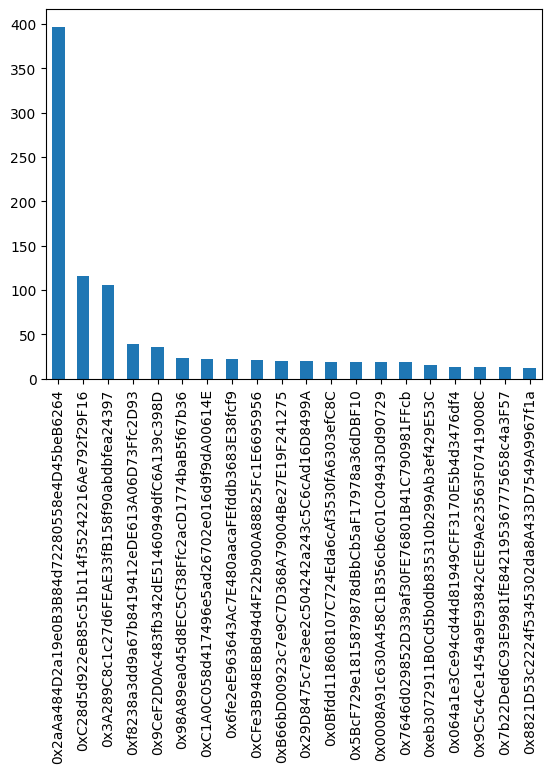

In [43]:
print(len(eth_high_alerts['attacker'].unique()))
eth_high_alerts['attacker'].value_counts()[:20].plot(kind='bar')

### Scrape Etherscan for Labels to help with ruling out false positives

In [199]:
import time
import requests
from lxml import html  
import csv,os,json
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from tqdm import tqdm

In [198]:
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

[WDM] - Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8.15M/8.15M [00:00<00:00, 45.0MB/s]


In [ ]:
# If any of our attacker addresses have labels on Etherscan, we can either confirm them as phishing, or rule them out
# as services or some other type of entity. There are other datasets we could use, but we will start with Etherscan.
# We will save these results, since scraping like this takes an exorbitant amount of time. Thank you Cloudflare.

In [233]:
attacker_labels = {}
token_labels = {}
contract_account = {}
contract_owner = {}
ca_phishing = {}


for attacker in tqdm(eth_alerts.attacker.unique()):
    page = driver.get('https://etherscan.io/address/'+attacker)
    try:
        label = driver.find_element('xpath','//*[@id="ContentPlaceHolder1_divSummary"]/div[1]/div[1]/div/div[1]/div/span/span')
        attacker_labels[attacker] = label.text
    except NoSuchElementException:
        try:
            secondary = driver.find_element('xpath', '//*[@id="ContentPlaceHolder1_divSummary"]/div[1]/div[1]/div/div[1]/div/span')
            attacker_labels[attacker] = secondary.text
        except NoSuchElementException:
            attacker_labels[attacker] = 'Unknown'
    try:
        token_label = driver.find_element('xpath', '//*[@id="ContentPlaceHolder1_tr_tokeninfo"]/div/div[2]/a')
        token_labels[attacker] = token_label.text
    except NoSuchElementException:
        token_labels[attacker] = "Unknown"
    try:
        add_type = driver.find_element('xpath', '//*[@id="content"]/div[1]/div/div[1]/h1')
        contract_account[attacker] = add_type.text
    except NoSuchElementException:
        contract_account[attacker] = 'Unknown'
    try:
        contract_owner_label = driver.find_element('xpath', '//*[@id="ContentPlaceHolder1_trContract"]/div/div[2]/a')
        contract_owner[attacker] = contract_owner_label.text  
    except NoSuchElementException:
        contract_owner[attacker] = 'Unknown'
    try:
        driver.get('https://www.chainabuse.com/address/'+attacker)
        ca_phishing_reports = driver.find_element('xpath', '//*[@id="__next"]/div/div/div/div[2]/div/section/div/div[1]/div[1]/div[1]/h3')
        ca_phishing[attacker] = ca_phishing_reports
    except Exception as e:
        print(e)
    time.sleep(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:13<00:00,  3.14s/it]


In [15]:
# It takes a long time to pull all alerts. We will focus our analysis on the period up to 16/09/2022

column_converters = {
    'source': literal_eval,
    'metadata': literal_eval,
    'addresses': literal_eval
}

eth_alerts_with_scrape = pd.read_csv('eth-alerts-with-scraped-data.csv', converters=column_converters)
eth_alerts_with_scrape.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
eth_alerts_with_scrape.columns

Index(['name', 'protocol', 'findingType', 'source', 'severity', 'metadata',
       'alertId', 'addresses', 'description', 'hash', 'chain_id',
       'block_number', 'attacker', 'alerted_tx', 'attacker_alert_count',
       'assets_impacted', 'attacker_labels', 'token_labels',
       'contract_account', 'contract_owner', 'ca_phishing'],
      dtype='object')

In [22]:
# Alerts are only available for the last month...

df_time_info = eth_alerts_with_scrape.sort_values(by=['block_number'])
print(df_time_info['block_number'].iloc[0], df_time_info['block_number'].iloc[-1])

15346634 15545060


In [76]:
unique_attackers = pd.DataFrame()

unique_attackers['attacker'] = eth_high_alerts.attacker.unique()

In [77]:
labels_df = eth_alerts_with_scrape[['attacker', 'attacker_labels', 'token_labels',
       'contract_account', 'contract_owner', 'ca_phishing']].drop_duplicates(subset=['attacker'], ignore_index=True)

In [87]:
phishing_labels = pd.merge(left=unique_attackers, right=labels_df, how='left', on='attacker')